In [34]:
import os 
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D, concatenate, Activation,Conv2DTranspose
from keras.layers.merge import concatenate,add
from keras.layers.normalization import BatchNormalization
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, History, ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.utils.generic_utils import get_custom_objects
from keras.utils import multi_gpu_model
from keras.models import Model

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from keras.regularizers import l2

from data import *
from metrics import iou_score
from metrics import jaccard_score
from metrics import f_score
from metrics import f1_score
from metrics import f2_score
from metrics import dice_score

from losses import jaccard_loss
from losses import bce_jaccard_loss
from losses import cce_jaccard_loss
from losses import dice_loss
from losses import bce_dice_loss
from losses import cce_dice_loss

os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

In [35]:
pwd

'/home/ubuntu/data3/JJB/Knee/JG_Knee'

In [36]:
epsilon = K.epsilon()
gamma = 0
alpha = 0.6
beta = 0.5

  
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


def balanced_loss(y_true, y_pred):
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    BL = alpha * CE
    
    return K.sum(BL, axis=1)


def focal_loss(y_true, y_pred):
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = alpha * K.pow(1-pt, gamma) * CE
    
    return K.sum(FL, axis=1)


def dice_coef(y_true, y_pred, smooth=0.001):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def cus_loss(y_true, y_pred):
    
    return (1 - beta) * focal_loss(y_true, y_pred) + beta * dice_coef_loss(y_true, y_pred)


def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T


get_custom_objects().update({
    
    'cus_loss': cus_loss,
    'iou_coef' : iou_coef,
    'f1score' : f1score,
    'precision' : precision,
    'recall' : recall,
    'balanced_loss' : balanced_loss,
    'focal_loss' : focal_loss,
    'dice_coef' : dice_coef,
    'dice_coef_loss' : dice_coef_loss,
    'cus_loss' : cus_loss,
    'tversky_loss' : tversky_loss,
        
})

img_size = 512

In [37]:
inputs = Input((img_size, img_size,1), dtype='float32')
conv1 = Conv2D(32, (3, 3), activation=None, padding='same')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)
conv1 = Conv2D(32, (3, 3), activation=None, padding='same')(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation=None, padding='same')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = Conv2D(64, (3, 3), activation=None, padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation=None, padding='same')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Activation('relu')(conv3)
conv3 = Conv2D(128, (3, 3), activation=None, padding='same')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation=None, padding='same')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Activation('relu')(conv4)
conv4 = Conv2D(256, (3, 3), activation=None, padding='same')(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(256, (3, 3), activation=None, padding='same')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Activation('relu')(conv5)
conv5 = Conv2D(256, (3, 3), activation=None, padding='same')(conv5)
conv5 = BatchNormalization()(conv5)
conv5 = Activation('relu')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation=None, padding='same')(up6)
conv6 = BatchNormalization()(conv6)
conv6 = Activation('relu')(conv6)
conv6 = Conv2D(256, (3, 3), activation=None, padding='same')(conv6)
conv6 = BatchNormalization()(conv6)
conv6 = Activation('relu')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation=None, padding='same')(up7)
conv7 = BatchNormalization()(conv7)
conv7 = Activation('relu')(conv7)
conv7 = Conv2D(128, (3, 3), activation=None, padding='same')(conv7)
conv7 = BatchNormalization()(conv7)
conv7 = Activation('relu')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation=None, padding='same')(up8)
conv8 = BatchNormalization()(conv8)
conv8 = Activation('relu')(conv8)
conv8 = Conv2D(64, (3, 3), activation=None, padding='same')(conv8)
conv8 = BatchNormalization()(conv8)
conv8 = Activation('relu')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation=None, padding='same')(up9)
conv9 = BatchNormalization()(conv9)
conv9 = Activation('relu')(conv9)
conv9 = Conv2D(32, (3, 3), activation=None, padding='same')(conv9)
conv9 = BatchNormalization()(conv9)
conv9 = Activation('relu')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=inputs, outputs=conv10)

# model.summary()

In [38]:
print("loading data")
img_size = 512
imgs_train = np.load('../data/npy/image_'+str(img_size)+'.npy')
imgs_mask_train = np.load('../data/npy/label_'+str(img_size)+'.npy')
image_test =np.load('../data/npy/test_'+str(img_size)+'.npy')
image_test_label = np.load('../data/npy/test_label_'+str(img_size)+'.npy')

imgs_train = imgs_train/255

imgs_mask_train = imgs_mask_train/255

image_test = image_test/255

image_test_label = image_test_label/255

print("loading data done")
print(imgs_train.shape)
print(imgs_mask_train.shape)
print(image_test.shape)
print(image_test_label.shape)

loading data
loading data done
(858, 512, 512, 1)
(858, 512, 512, 1)
(226, 512, 512, 1)
(226, 512, 512, 1)


In [39]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)


model.compile(optimizer=Adam(lr=0.001), loss=dice_coef_loss, metrics=['accuracy', recall, precision, f1score, dice_coef])

In [40]:
#################
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, min_delta=1e-8)
earlystopper = EarlyStopping(monitor='val_loss',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint('../result/model_IMT_rck_dice_best_'+str(img_size)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
#용이하게 하는곳 
callbacks_list = [reduce_lr, model_checkpoint, earlystopper]

In [41]:
print('Fitting model...')
print('-'*200)
hist = model.fit(imgs_train, imgs_mask_train, batch_size=8, epochs=100, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks_list)# ->여기서는 트레인 라벨 O
#학습을 하는코드(fit) 용량 문제 (리소스) batch_szie
print('-'*200)
print('predict test data')
print('-'*200)
imgs_mask_test = model.predict(image_test, batch_size=30, verbose=1)# predict 예측 -> 여기서는 테스트 라벨 x
np.save('../result/npy/test_pred_rck_dice_'+str(img_size)+'.npy', imgs_mask_test)
print('-'*200)
print('predict test data save done')
print('-'*200)

Fitting model...
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Train on 686 samples, validate on 172 samples
Epoch 1/100
686/686 [==============================] - 37s 54ms/step - loss: 0.4806 - acc: 0.9337 - recall: 0.9516 - precision: 0.6955 - f1score: 0.7674 - dice_coef: 0.5194 - val_loss: 0.5685 - val_acc: 0.8947 - val_recall: 0.9809 - val_precision: 0.3535 - val_f1score: 0.5192 - val_dice_coef: 0.4315

Epoch 00001: val_loss improved from inf to 0.56849, saving model to ../result/model_IMT_rck_dice_best_512.h5
Epoch 2/100
686/686 [==============================] - 31s 45ms/step - loss: 0.2020 - acc: 0.9885 - recall: 0.9381 - precision: 0.9008 - f1score: 0.9178 - dice_coef: 0.7980 - val_loss: 0.4212 - val_acc: 0.9346 - val_recall: 0.9842 - val_precision: 0.4737 - val_f1score: 0.6389 - val_dice_coef: 0.5788

Epoch 00002: val_loss i

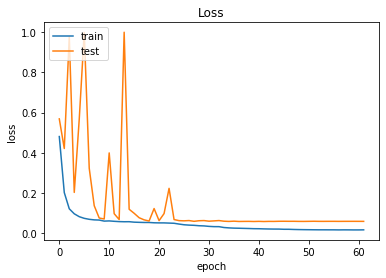

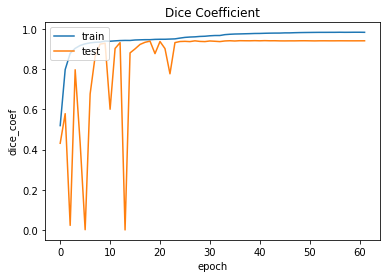

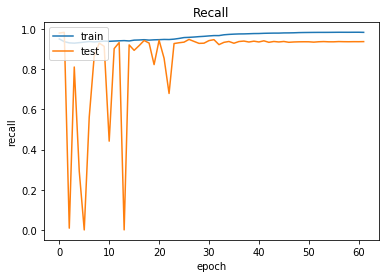

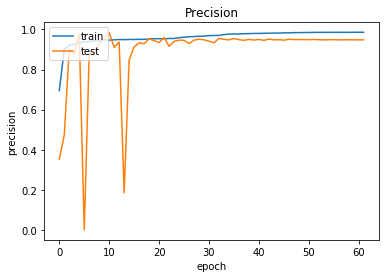

In [42]:
fig = plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


fig = plt.figure()
plt.plot(hist.history['dice_coef'])
plt.plot(hist.history['val_dice_coef'])
plt.title('Dice Coefficient')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

fig = plt.figure()
plt.plot(hist.history['recall'])
plt.plot(hist.history['val_recall'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

fig = plt.figure()
plt.plot(hist.history['precision'])
plt.plot(hist.history['val_precision'])
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
def preds_Thresh(preds_test,Thresh_value):
    #저위에있는 프레딕트를 나온 결과가 확률(0~1)
    preds_mask = np.ndarray((len(imgs_mask_test),img_size, img_size, 1), dtype=np.float32)
  
    preds_mask0 = preds_test[:,:,:,0] > Thresh_value# thresh_value 
  
    preds_mask[:,:,:,0] = preds_mask0*1#
    
    return preds_mask

(-0.5, 511.5, 511.5, -0.5)

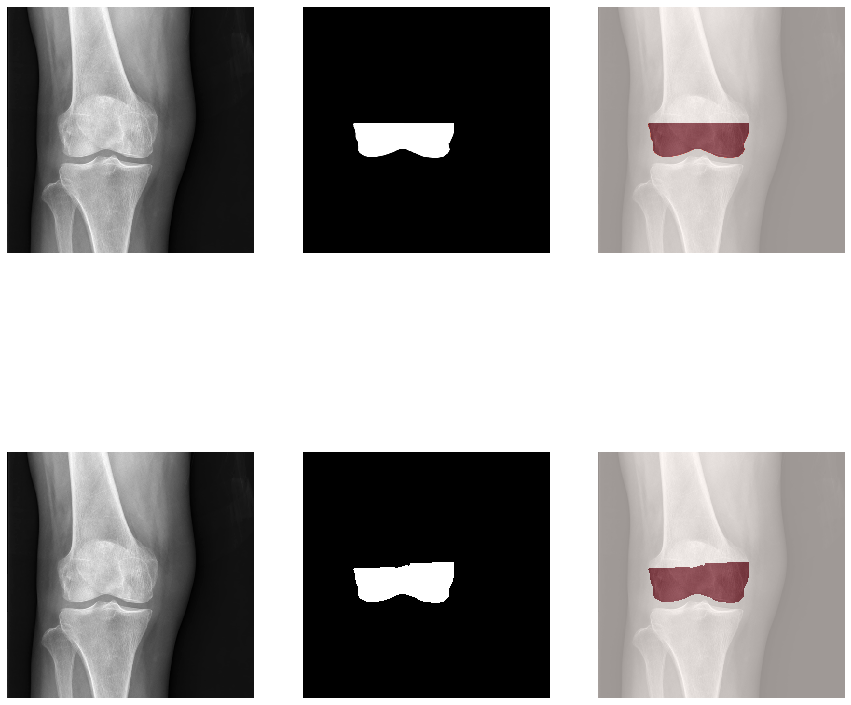

In [47]:
preds_mask = preds_Thresh(imgs_mask_test,0.5)# 0.5이상이면 1 , 아니면 0

toto = 100
plt.figure(figsize=(15, 15))
plt.subplot(2,3,1)
plt.imshow(image_test[toto,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,3,2)
plt.imshow(image_test_label[toto,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,3,3)
plt.imshow(image_test[toto,:,:,0],cmap='gray')
plt.imshow(image_test_label[toto,:,:,0],cmap='Reds' ,alpha=0.6)
plt.axis('off')
plt.subplot(2,3,4)
plt.imshow(image_test[toto,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,3,5)
plt.imshow(preds_mask[toto,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,3,6)
plt.imshow(image_test[toto,:,:,0],cmap='gray')
plt.imshow(preds_mask[toto,:,:,0],cmap='Reds' ,alpha=0.6)
plt.axis('off')

In [48]:
print("array to image")
preds_mask_1 = preds_mask
imgs_name = np.load('../data/npy/test_name_512.npy')
for i in range(preds_mask_1.shape[0]):
    img = preds_mask_1[i]
    img = array_to_img(img)
    img.save("../result/img/%s_rck_dice_pred.bmp"%imgs_name[i])

array to image


In [15]:
_loss, _acc, _precision, _recall, _f1score, _dice_coef = model.evaluate(image_test, image_test_label, batch_size=30, verbose=1)
print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}, dice_coef:{:.3f}'.format(_loss, _acc*100, _precision*100, _recall*100, _f1score*100, _dice_coef*100))

186/186 [==============================] - 2s 11ms/step
loss: 0.281, accuracy: 98.834, precision: 71.977, recall: 80.692, f1score: 75.997, dice_coef:71.868


In [16]:
image_test_label_ravel = np.ravel(image_test_label)
image_test_label_ravel_cur = image_test_label_ravel.astype(np.bool)

predic_ravel = np.ravel(model.predict(image_test, batch_size=10))

predic_ravel = predic_ravel.astype(np.float32)

In [17]:
precision_, recall_, thresholds_ = precision_recall_curve(image_test_label_ravel_cur, predic_ravel)

average_precision_score = average_precision_score(image_test_label_ravel_cur, predic_ravel)

In [18]:
fpr_, tpr_, thresholds_1 = roc_curve(image_test_label_ravel_cur, predic_ravel)

roc_auc_score_ = roc_auc_score(image_test_label_ravel_cur, predic_ravel)

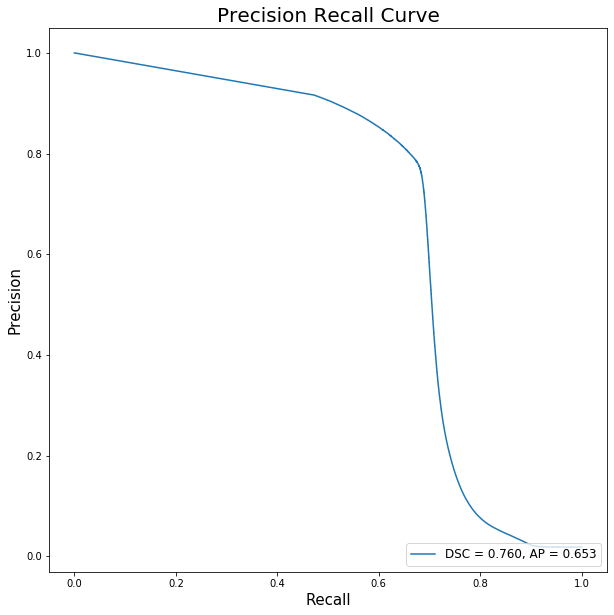

In [19]:
fig = plt.figure(figsize=(10,10))

plt.title('Precision Recall Curve', fontsize=20)

plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)

plt.plot(recall_, precision_, label='DSC = %0.3f, AP = %0.3f'%(_f1score, average_precision_score))

plt.legend(loc='lower right', fontsize=12)
plt.show()
fig.savefig('../result/fig/rck_dice_precision_recall_curve.png')

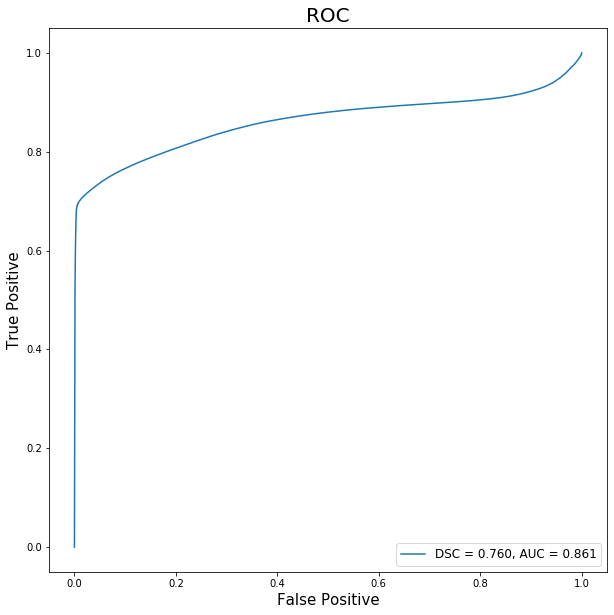

In [20]:
fig = plt.figure(figsize=(10,10))

plt.title('ROC', fontsize=20)

plt.xlabel('False Positive', fontsize=15)
plt.ylabel('True Positive', fontsize=15)

plt.plot(fpr_, tpr_, label='DSC = %0.3f, AUC = %0.3f'%(_f1score, roc_auc_score_))

plt.legend(loc='lower right', fontsize=12)
plt.show()
fig.savefig('../result/fig/rck_dice_ROC.png')

In [1]:
pwd

'/home/ubuntu/data3/JG_Jeong/cardiac/IMT_Segmentation/code'